### Controlled: Autocorrelation

Fixed : Grid size, Average variable value

SAR Model

The SAR model is a statistical model designed to account for spatial autocorrelation, i.e., the idea that observations close to each other in space are more likely to have similar values than those further apart.


\begin{equation}
y = \rho W y + \epsilon
\end{equation}

where:
- \(y\) is the dependent variable
- \(\rho\) is the spatial autoregressive parameter
- \(W\) is the spatial weights matrix
- \(\epsilon\) is the error term






In [1]:

import numpy as np
import scipy.sparse as sp
from scipy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shapely import geometry as geom
import geopandas as gpd


In [2]:
# def create_rook_adjacency(n):
#     """
#     Create a rook adjacency matrix for an n x n grid.
#     Each cell is connected to its 4 adjacent neighbors (north, south, east, west).
    
#     Parameters:
#     -----------
#     n : int
#         Size of the grid (n x n)
        
#     Returns:
#     --------
#     W : scipy.sparse.csr_matrix
#         Sparse adjacency matrix (n² x n²)
#     """
#     W = sp.lil_matrix((n * n, n * n))
#     for row in range(n):
#         for col in range(n):
#             idx = row * n + col
#             # Connect to adjacent cells (rook pattern)
#             if row > 0:  # North
#                 W[idx, (row - 1) * n + col] = 1
#             if row < n - 1:  # South
#                 W[idx, (row + 1) * n + col] = 1
#             if col > 0:  # West
#                 W[idx, row * n + (col - 1)] = 1
#             if col < n - 1:  # East
#                 W[idx, row * n + (col + 1)] = 1
    
#     # Return as CSR format for efficient operations
#     return W.tocsr()


In [3]:
def create_queen_adjacency(n):
    """
    Create a queen adjacency matrix for an n x n grid.
    Each cell is connected to its 8 adjacent neighbors (N, S, E, W, NE, NW, SE, SW).
    
    Parameters:
    -----------
    n : int
        Size of the grid (n x n)
        
    Returns:
    --------
    W : scipy.sparse.csr_matrix
        Sparse adjacency matrix (n² x n²)
    """
    W = sp.lil_matrix((n * n, n * n))
    for row in range(n):
        for col in range(n):
            idx = row * n + col
            
            # Cardinal directions (same as rook)
            if row > 0:  # North
                W[idx, (row - 1) * n + col] = 1
            if row < n - 1:  # South
                W[idx, (row + 1) * n + col] = 1
            if col > 0:  # West
                W[idx, row * n + (col - 1)] = 1
            if col < n - 1:  # East
                W[idx, row * n + (col + 1)] = 1
                
            # Diagonal connections (unique to queen)
            if row > 0 and col > 0:  # Northwest
                W[idx, (row - 1) * n + (col - 1)] = 1
            if row > 0 and col < n - 1:  # Northeast
                W[idx, (row - 1) * n + (col + 1)] = 1
            if row < n - 1 and col > 0:  # Southwest
                W[idx, (row + 1) * n + (col - 1)] = 1
            if row < n - 1 and col < n - 1:  # Southeast
                W[idx, (row + 1) * n + (col + 1)] = 1
    
    # Return as CSR format for efficient operations
    return W.tocsr()

In [4]:
def row_standardize_sparse(W):
    """
    Row-standardize a sparse matrix efficiently.
    
    Parameters:
    -----------
    W : scipy.sparse.csr_matrix
        Input sparse matrix
        
    Returns:
    --------
    W_std : scipy.sparse.csr_matrix
        Row-standardized sparse matrix
    """
    W_csr = W.tocsr()
    row_sums = np.array(W_csr.sum(axis=1)).flatten()
    # Handle zero row sums to avoid division by zero
    row_sums[row_sums == 0] = 1
    
    # Create diagonal matrix with inverse of row sums
    D_inv = sp.diags(1.0 / row_sums)
    
    # Multiply to get row-standardized matrix
    W_std = D_inv @ W_csr
    return W_std

The function simulates values based on the sar model,

\begin{equation}
y = (I - \rho W)^{-1} \epsilon
\end{equation}

where:
- \(I\) is the identity matrix

In [5]:
def simulate_sar_fixed_mean(W, rho, fixed_mean=0.15, sigma=1.0, random_seed=None):
    """
    Simulate a Spatial Autoregressive (SAR) process with a fixed mean.
    
    Model: y = (I - ρW)^(-1) * ε
    
    Parameters:
    -----------
    W : scipy.sparse.csr_matrix
        Row-standardized spatial weights matrix
    rho : float
        Spatial autocorrelation parameter (between 0 and 1)
    fixed_mean : float
        Target mean for the output values
    sigma : float
        Standard deviation of the error terms
    random_seed : int or None
        Random seed for reproducibility
        
    Returns:
    --------
    y : numpy.ndarray
        Simulated values with the specified autocorrelation and mean
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n = W.shape[0]
    I = sp.identity(n, format='csr')
    
    # Generate random error terms
    epsilon = np.random.normal(0, sigma, size=n)
    
    # Calculate (I - ρW)^(-1)
    # For large matrices, consider using sparse solvers instead of direct inversion
    A_inv = inv((I - rho * W).toarray())
    
    # Compute SAR process: y = (I - ρW)^(-1) * ε
    y = A_inv @ epsilon
    
    # Adjust to the target mean while preserving variance structure
    y = y - np.mean(y) + fixed_mean # Since the SAR process doesn't inherently control the mean
    
    return y

In [6]:
def visualize_spatial_autocorrelation(simulations, n, rhos, fixed_mean, cmap='coolwarm'):
    """
    Visualize spatial autocorrelation with different parameters.
    
    Parameters:
    -----------
    simulations : dict
        Dictionary with rho values as keys and simulated data as values
    n : int
        Grid size (n x n)
    rhos : list
        List of rho values used in simulations
    fixed_mean : float
        Target mean used in simulations
    cmap : str
        Colormap for visualization
    """
    fig, axs = plt.subplots(1, len(rhos), figsize=(5*len(rhos), 5))
    
    # Find global min and max for consistent color scaling
    vmin = min(sim.min() for sim in simulations.values())
    vmax = max(sim.max() for sim in simulations.values())
    
    for i, rho in enumerate(rhos):
        sim_data = simulations[rho].reshape((n, n))
        im = axs[i].imshow(sim_data, cmap=cmap, vmin=vmin, vmax=vmax)
        axs[i].set_title(f"ρ = {rho}\nMean = {simulations[rho].mean():.3f}")
        axs[i].axis('off')
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    plt.suptitle(f"Spatial Autocorrelation Simulation (Fixed Mean = {fixed_mean})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    return fig

Main Function

In [7]:
# Parameters
n = 12  # Grid size
fixed_mean = 0.8
sigma = 1.0
random_seed = 42

# Create adjacency matrix
W = create_queen_adjacency(n)

# Row-standardize the weights matrix
W_std = row_standardize_sparse(W)

# Simulate with different autocorrelation levels
# rhos = [-0.7,-0.3,0.0, 0.3, 0.7]
rhos = [-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

simulations = {
    rho: simulate_sar_fixed_mean(W_std, rho, fixed_mean=fixed_mean, 
                                    sigma=sigma, random_seed=random_seed) 
    for rho in rhos
}

#  # Visualize
# fig = visualize_spatial_autocorrelation(simulations, n, rhos, fixed_mean)
# plt.show()

# # Additional visualization: histogram of values for each rho
# plt.figure(figsize=(12, 5))
# for rho in rhos:
#     sns.kdeplot(simulations[rho], label=f"ρ = {rho}")

# plt.axvline(x=fixed_mean, color='black', linestyle='--', label=f"Target Mean = {fixed_mean}")
# plt.title("Distribution of Values Across Different Spatial Autocorrelation Levels")
# plt.xlabel("Value")
# plt.ylabel("Density")
# plt.legend()
# plt.tight_layout()
# plt.show()


Let's create df for each rho including geometry

In [8]:
def create_dfs_for_simulations(simulations, rhos, n):
    """
    Create a DataFrame for each simulation result.
    
    Parameters:
    -----------
    simulations : dict
        Dictionary with rho values as keys and simulated data as values
    rhos : list
        List of rho values used in simulations
    n : int
        Grid size (n x n)
        
    Returns:
    --------
    dfs : dict
        Dictionary with rho values as keys and DataFrames as values
    """
    geodataframes = {}
    df_index = pd.DataFrame({'Index': np.arange(n**2)})

    # Function to calculate square coordinates based on the grid index
    def calculate_square_coordinates(row,n):
        value = row['Index']
        x = value % n
        y = value // n
        return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    
    df_index['geometry'] = df_index.apply(calculate_square_coordinates, axis=1, n=n)
    

    for rho in rhos:
        temp_df = df_index.copy()
        temp_df['Value'] = simulations[rho]

        temp_gdf = gpd.GeoDataFrame(temp_df, geometry='geometry')

        geodataframes[rho] = temp_gdf
    
    return geodataframes

In [9]:
geo_dataframes = create_dfs_for_simulations(simulations, rhos, n)

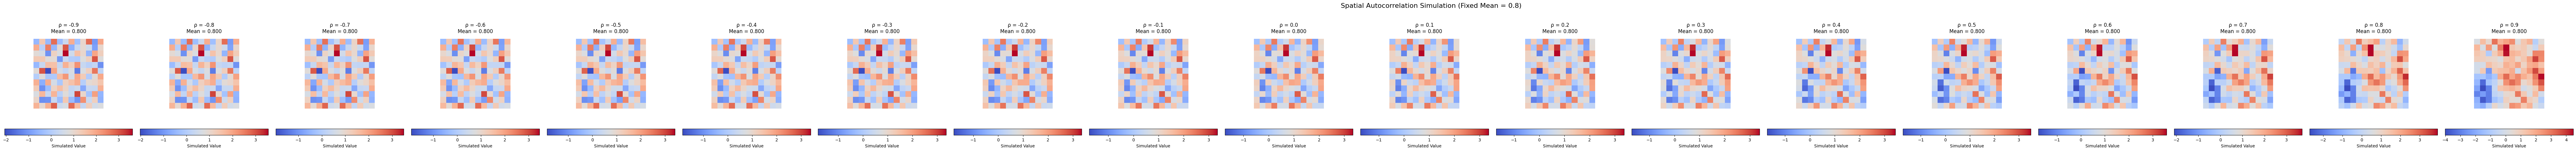

In [10]:
# plotting the geodataframes
fig, axs = plt.subplots(1, len(rhos), figsize=(5*len(rhos), 5))

for i, rho in enumerate(rhos):
    geo_dataframes[rho].plot(column='Value', ax=axs[i], legend=True, cmap='coolwarm', 
                              legend_kwds={'label': "Simulated Value", 'orientation': "horizontal"})
    axs[i].set_title(f"ρ = {rho}\nMean = {geo_dataframes[rho]['Value'].mean():.3f}")
    axs[i].axis('off')
plt.suptitle(f"Spatial Autocorrelation Simulation (Fixed Mean = {fixed_mean})", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

Extract the TDA summaries

In [11]:
from utills.geodata import generate_grid_dataframe,calculate_moran_i

from utills.adjacency_simplex import AdjacencySimplex 
from utills.calculate_tda_summaries import compute_persistence

In [12]:
results_df = pd.DataFrame(columns=['GDF','Filter Method','TL','AL','TML','AML','Average'])

for rho in rhos:

    gdf = geo_dataframes[rho]

    average = gdf['Value'].mean()

    adj_simplex =AdjacencySimplex(gdf, 'Value', threshold = None, filter_method = 'down')

    # Filter the GeoDataFrame
    filtered_df,gdf_id = adj_simplex.filter_sort_gdf()

    # Calculate the adjacent countries
    adj_simplex.calculate_adjacent_countries()

    # Form the simplicial complex
    simplex = adj_simplex.form_simplicial_complex()

    # Compute the persistence
    _,TL, AL, TML, AML,_ = compute_persistence(simplices=simplex,filtered_df=filtered_df,variable_name='Value')

    # Add the results to the results_df
    new_row = pd.DataFrame({'GDF': rho,
                                'Filter Method': ['down'],
                                'TL': [TL],
                                'AL': [AL],
                                'TML': [TML],
                                'AML': [AML],
                                'Average': average},
                                )
    results_df = pd.concat([results_df, new_row], ignore_index=True)



In [13]:
results_df

,GDF,Filter Method,TL,AL,TML,AML,Average
0,-0.9,down,435.628725,3.025199,217.814362,1.512600,0.8
1,-0.8,down,424.393153,2.947175,212.196577,1.473587,0.8
2,-0.7,down,414.942432,2.881545,207.471216,1.440772,0.8
3,-0.6,down,407.080498,2.826948,203.540249,1.413474,0.8
4,-0.5,down,400.645823,2.782263,200.322911,1.391131,0.8
5,-0.4,down,395.462833,2.746270,197.731417,1.373135,0.8
6,-0.3,down,391.450986,2.718410,195.725493,1.359205,0.8
7,-0.2,down,388.574329,2.698433,194.287164,1.349216,0.8
8,-0.1,down,386.851992,2.686472,193.425996,1.343236,0.8
9,0.0,down,386.298268,2.682627,193.149134,1.341313,0.8


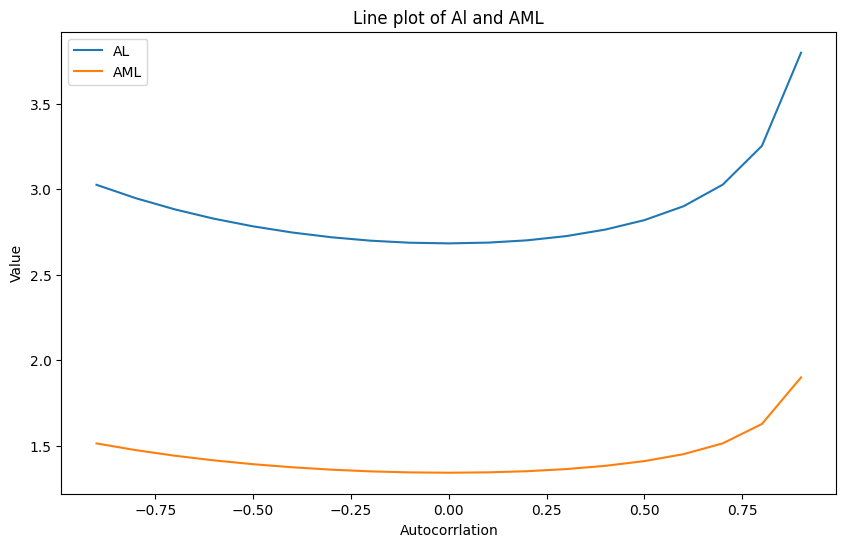

In [14]:
# plot a line plot of the results X axis is GDF and Y axis is TL, AL, TML, AML
fig, ax = plt.subplots(figsize=(10, 6))
for col in ['AL', 'AML']:
    ax.plot(results_df['GDF'], results_df[col], label=col)
ax.set_xlabel('Autocorrlation')
ax.set_ylabel('Value')
ax.set_title('Line plot of Al and AML')
ax.legend()
plt.show()